# **Difference in VIX levels by Moon Phase & Weather Conditions (NYC)**
___
## Index:
- [Data Prep](#DataPrep)
- [Heatmap of VIX by Moon Phase & Weather Conditions](#Heatmap)
- [Correlation Matrix of VIX with features](#CorrMatrix)
- [Boxplot of VIX by Moon Phase](#Boxplot)
---

## **Import Packages:**
<a name="DataPrep"></a>

In [1]:
#!pip install ephem
#!pip install meteostat
#!pip install pandas_datareader
import ephem
from meteostat import Stations, Daily
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## **Specify start and end dates:**

In [2]:
start_date = pd.Timestamp(datetime.date(1990, 1, 1))
end_date = pd.Timestamp(datetime.date(2023, 10, 31))

## **Define functions:**

Return the moon phase name for a given value

In [3]:
def moon_phase_name(phase):
    if 0 <= phase < 5:
        return "New Moon"
    elif 5 <= phase < 20:
        return "Waxing Crescent"
    elif 20 <= phase < 45:
        return "First Quarter (Waxing Half Moon)"
    elif 45 <= phase < 70:
        return "Waxing Gibbous"
    elif 70 <= phase < 85:
        return "Full Moon"
    else:
        return "Waning Gibbous"

Check if Mercury is in retrograde on the given date

In [4]:
def is_mercury_retrograde(date):
    mercury = ephem.Mercury(date)
    previous_ra = ephem.Mercury(ephem.Date(date) - 1).ra
    return mercury.ra < previous_ra

Get Weather data for NYC

In [5]:
# Identify a weather station for NYC
stations = Stations()
station = stations.nearby(40.7128, -74.0060).fetch(1)
station_id = station.index[0]
# Fetch historical weather data for NYC using Meteostat
daily = Daily(station_id, start=start_date, end=end_date)
weather_data = daily.fetch()
weather_data.tail()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2023-10-27,19.2,16.0,24.0,0.1,NaN,260.0,8.8,NaN,1019.6,NaN
2023-10-28,21.7,17.8,27.8,0.0,NaN,262.0,10.5,NaN,1016.8,NaN
2023-10-29,13.6,12.0,17.8,6.0,NaN,34.0,17.7,NaN,1018.8,NaN
2023-10-30,13.7,11.0,16.1,0.1,NaN,350.0,8.9,NaN,1010.6,NaN
2023-10-31,10.9,9.0,13.0,0.2,NaN,41.0,9.3,NaN,1018.0,NaN


Fetch VIX data from FRED and apply functions

In [6]:
sp500 = web.DataReader('VIXCLS', 'fred', start_date, end_date)
# Compute moon phase values for the trading days
moon_phases = [ephem.Moon(date).phase for date in sp500.index]
# Add moon phase values to the DataFrame
sp500['MoonPhase'] = moon_phases
# Add MoonPhaseName to the DataFrame
sp500['MoonPhaseName'] = sp500['MoonPhase'].apply(moon_phase_name)
# Compute Mercury retrograde status for the trading days
mercury_retrograde_status = [is_mercury_retrograde(date) for date in sp500.index]
# Add Mercury Retrograde status to the DataFrame
sp500['MercuryRetrograde'] = mercury_retrograde_status
# Add Rainfall data and a Raining column (True if Rainfall > 0)
sp500['Rainfall'] = sp500.index.map(weather_data['prcp'].to_dict()).fillna(0)
sp500['Raining'] = sp500['Rainfall'] > 0
sp500['Windspeed'] = sp500.index.map(weather_data['wspd'].to_dict()).fillna(0)
sp500['Windy'] = sp500['Windspeed'] > 20
sp500['Temp'] = sp500.index.map(weather_data['tavg'].to_dict()).fillna(0)
sp500['Hot'] = sp500['Temp'] > 25
# Compute daily percent change for the VIX
sp500['VIX_pct'] = sp500['VIXCLS'].pct_change() * 100  # in percentage
sp500.tail()

,VIXCLS,MoonPhase,MoonPhaseName,MercuryRetrograde,Rainfall,Raining,Windspeed,Windy,Temp,Hot,VIX_pct
DATE,,,,,,,,,,,
2023-10-25,20.19,80.805817,Full Moon,False,0.0,False,12.2,False,17.2,False,6.431207
2023-10-26,20.68,89.183235,Waning Gibbous,False,0.0,False,8.3,False,20.1,False,2.426944
2023-10-27,21.27,95.384964,Waning Gibbous,False,0.1,True,8.8,False,19.2,False,2.852998
2023-10-30,19.75,98.260544,Waning Gibbous,False,0.1,True,8.9,False,13.7,False,-7.146215
2023-10-31,18.14,94.209229,Waning Gibbous,False,0.2,True,9.3,False,10.9,False,-8.151899


## **Create Heatmap:**
<a name="Heatmap"></a>

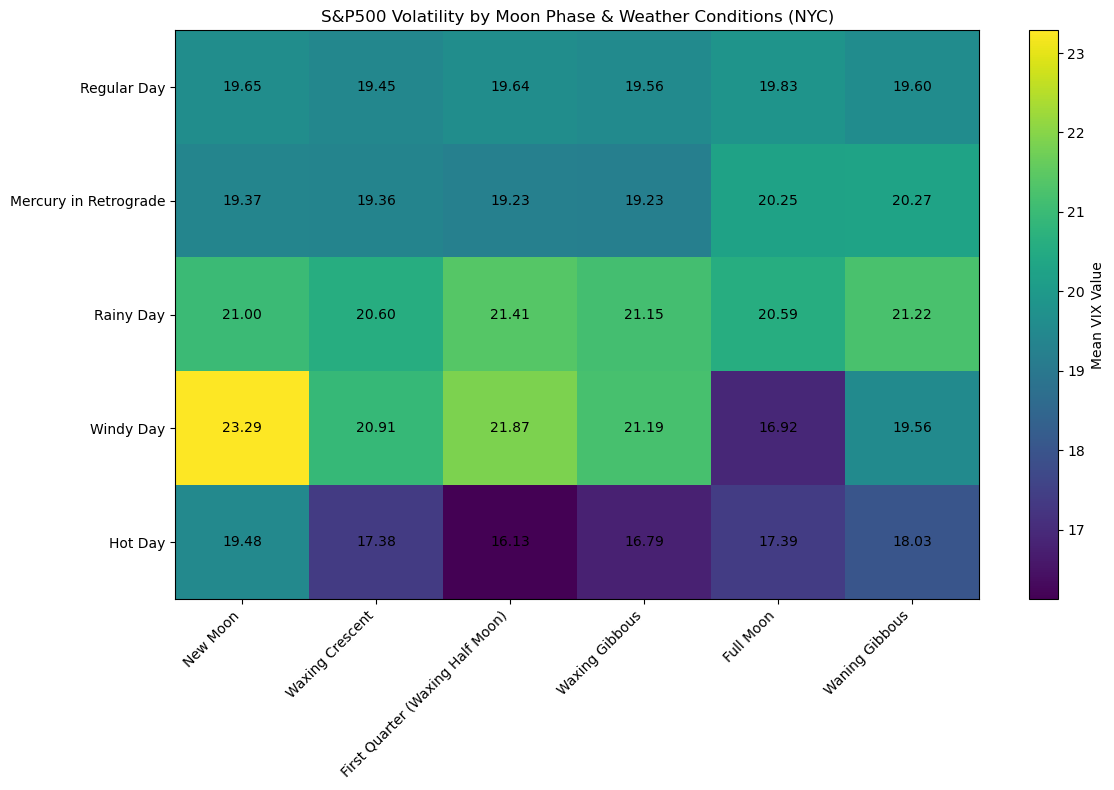

In [7]:
# Define the ordered moon phases
ordered_moon_phases = ["New Moon", "Waxing Crescent", "First Quarter (Waxing Half Moon)", "Waxing Gibbous", "Full Moon", "Waning Gibbous"]
# Group and stack data by MoonPhaseName and compute the mean for VIXCLS
heatmap_data = pd.DataFrame({
    'Regular Day': sp500.groupby('MoonPhaseName')['VIXCLS'].mean().reindex(ordered_moon_phases),
    'Mercury in Retrograde': sp500[sp500['MercuryRetrograde']].groupby('MoonPhaseName')['VIXCLS'].mean().reindex(ordered_moon_phases),
    'Rainy Day': sp500[sp500['Raining']].groupby('MoonPhaseName')['VIXCLS'].mean().reindex(ordered_moon_phases),
    'Windy Day': sp500[sp500['Windy']].groupby('MoonPhaseName')['VIXCLS'].mean().reindex(ordered_moon_phases),
    'Hot Day': sp500[sp500['Hot']].groupby('MoonPhaseName')['VIXCLS'].mean().reindex(ordered_moon_phases)
}).T

# Update the heatmap to include values for each cell and use viridis colormap
plt.figure(figsize=(12, 8))
cax = plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(cax, label='Mean VIX Value')
# Add values to each cell
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        plt.text(j, i, f"{heatmap_data.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.yticks(np.arange(heatmap_data.shape[0]), heatmap_data.index)
plt.xticks(np.arange(len(ordered_moon_phases)), ordered_moon_phases, rotation=45, ha='right')
plt.title('S&P500 Volatility by Moon Phase & Weather Conditions (NYC)')
plt.tight_layout()
plt.show()

## **Correlation Matrix:**
<a name="CorrMatrix"></a>

In [8]:
sp500.dropna(inplace=True)
moon_period_exact = 100  # MoonPhase goes from 0 to 100
sp500['cos_feature_exact'] = np.cos(2 * np.pi * sp500['MoonPhase'] / moon_period_exact)
sp500['sin_feature_exact'] = np.sin(2 * np.pi * sp500['MoonPhase'] / moon_period_exact)
sp500 = pd.concat([sp500,pd.get_dummies(sp500['MoonPhaseName'])],axis=1)
sp500['VIX_high'] = sp500['VIXCLS'].apply(lambda x: 1 if x > 30 else 0)
sp500.corr()['VIXCLS'].abs().sort_values(ascending=False)

VIXCLS                              1.000000
VIX_high                            0.714210
VIX_pct                             0.107008
Hot                                 0.046908
Raining                             0.042111
Temp                                0.033904
Windy                               0.017435
Rainfall                            0.016920
Full Moon                           0.010123
Waxing Crescent                     0.008525
cos_feature_exact                   0.003375
MoonPhase                           0.003019
MercuryRetrograde                   0.002844
Waxing Gibbous                      0.002806
sin_feature_exact                   0.002409
New Moon                            0.001734
First Quarter (Waxing Half Moon)    0.001726
Waning Gibbous                      0.000972
Windspeed                           0.000401
Name: VIXCLS, dtype: float64

## **Boxplot of VIX by Moon Phase:**
<a name="Boxplot"></a>

<Axes: xlabel='MoonPhaseName', ylabel='VIXCLS'>

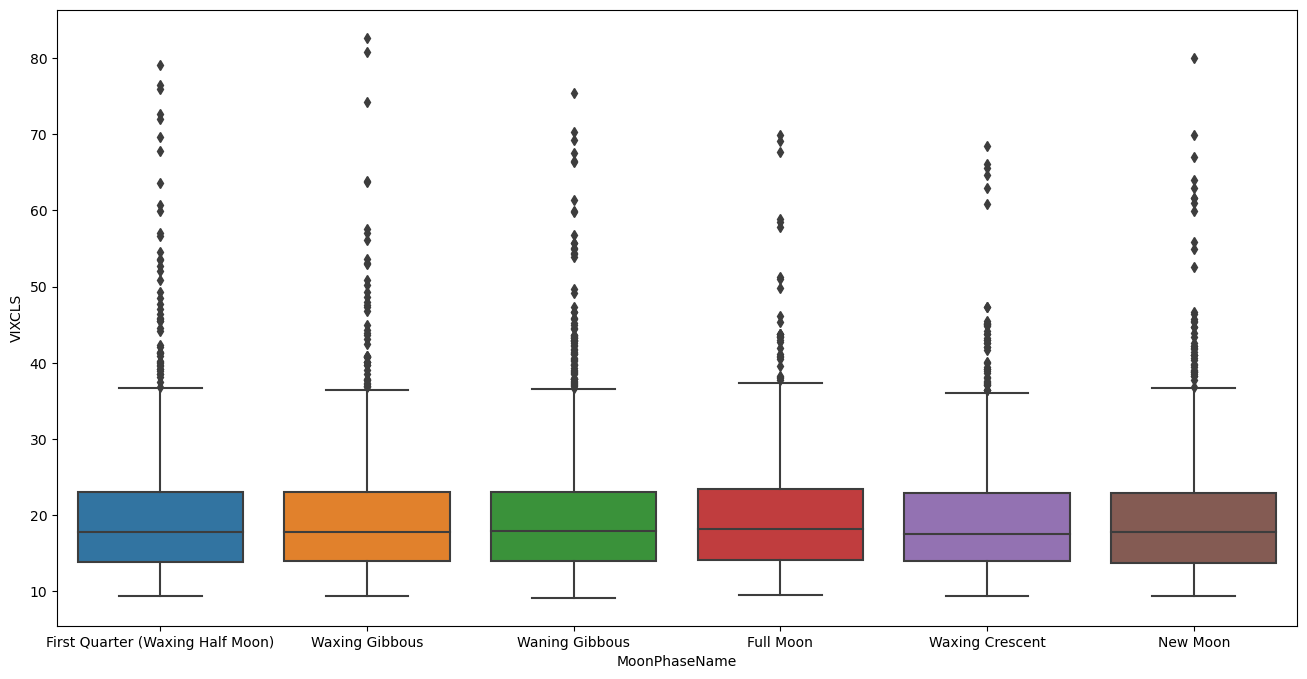

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(16,8))
sns.boxplot(x="MoonPhaseName", y="VIXCLS", data=sp500)